In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
from scipy import stats
from sklearn.metrics.cluster import adjusted_rand_score
import STAGATE
import tensorflow as tf
import os

tf.compat.v1.disable_eager_execution()
import anndata as ad
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import STAGATE
import scanpy as sc

def run_stagate_mclust(adata_path, num_cluster=7, used_obsm='STAGATE', random_seed=0):
    adata = ad.read_h5ad(adata_path)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
    STAGATE.Stats_Spatial_Net(adata)
    adata = STAGATE.train_STAGATE(adata, alpha=0)

    utils = rpackages.importr('utils')
    if not rpackages.isinstalled('mclust'):
        print("Installing 'mclust' R package...")
        utils.install_packages('mclust')
    

    robjects.r.library("mclust")

    adata = STAGATE.mclust_R(adata, num_cluster=num_cluster, used_obsm=used_obsm, random_seed=random_seed)

    sc.pp.neighbors(adata, use_rep=used_obsm)
    sc.tl.umap(adata)
    
    return adata


2024-11-03 13:59:44.198569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-03 13:59:44.210204: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-03 13:59:44.213927: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-03 13:59:44.222931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/bin/bash: /mnt/volume2/SRTP/anacon

------Calculating spatial graph...
The graph contains 20510 edges, 3553 cells.
5.7726 neighbors per cell on average.
Size of Input:  (3553, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1730613760.606141 1329445 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-03 14:02:40.607843: W tensorflow/core/common

fitting ...
  |======================================================================| 100%


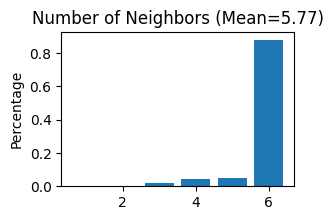

In [3]:
raw_result = run_stagate_mclust("/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/simulated_domain_151673_filtered.h5ad", num_cluster=7, used_obsm='STAGATE', random_seed=1)

In [4]:
raw_result

AnnData object with n_obs × n_vars = 2873 × 10629
    obs: 'in_tissue', 'array_row', 'array_col', 'imagerow', 'imagecol', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'discard', 'cell_count', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'n_genes', 'mclust'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'Spatial_Net', 'neighbors', 'umap', 'mclust_colors'
    obsm: 'spatial', 'STAGATE', 'X_umap'
    obsp: 'distances', 'connectivities'

/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


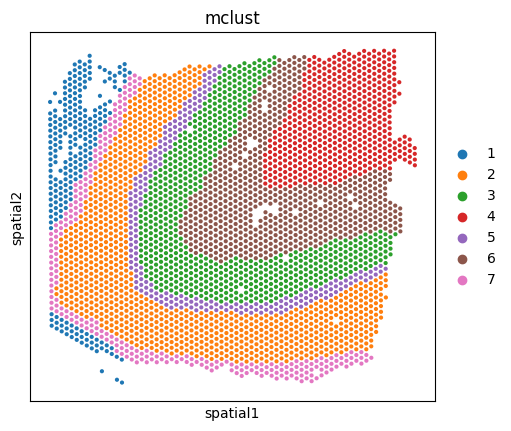

/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))


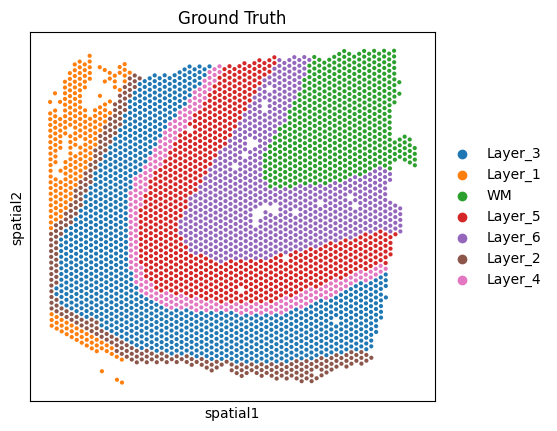

In [5]:
sc.pl.spatial(raw_result, color='mclust', spot_size=100, cmap='tab20')
sc.pl.spatial(raw_result, color='Ground Truth', spot_size=100, cmap='tab20')

In [2]:

def calculate_metrics(data):
    if scipy.sparse.issparse(data):
        data = data.toarray()
    
    gene_mean = np.mean(data, axis=0)
    gene_var = np.var(data, axis=0)
    gene_cv = np.divide(np.sqrt(gene_var), gene_mean, where=gene_mean!=0)
    gene_zero_prop = np.mean(data == 0, axis=0)
    
    loc_zero_prop = np.mean(data == 0, axis=1)
    library_size = np.sum(data, axis=1)
    
    return {
        'gene_mean': gene_mean,
        'gene_var': gene_var,
        'gene_cv': gene_cv,
        'gene_zero_prop': gene_zero_prop,
        'loc_zero_prop': loc_zero_prop,
        'library_size': library_size
    }

def compare_metrics(real_metrics, sim_metrics):
    comparison = {}
    for metric in real_metrics.keys():
        if metric in ['gene_mean', 'gene_var', 'gene_cv', 'gene_zero_prop']:
            comparison[f'{metric}_correlation'] = stats.pearsonr(real_metrics[metric], sim_metrics[metric])[0]
        elif metric in ['loc_zero_prop', 'library_size']:
            comparison[f'{metric}_ks_statistic'] = stats.ks_2samp(real_metrics[metric], sim_metrics[metric]).statistic
    
    return comparison

def plot_comparison(real_metrics, sim_metrics):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    
    metrics = ['gene_mean', 'gene_var', 'gene_cv', 'gene_zero_prop', 'loc_zero_prop', 'library_size']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        if metric in ['gene_mean', 'gene_var', 'gene_cv', 'gene_zero_prop']:
            sns.scatterplot(x=real_metrics[metric], y=sim_metrics[metric], ax=ax)
            ax.set_xlabel(f'Real {metric}')
            ax.set_ylabel(f'Simulated {metric}')
            ax.set_title(f'{metric} comparison')
        else:
            sns.kdeplot(real_metrics[metric], ax=ax, label='Real')
            sns.kdeplot(sim_metrics[metric], ax=ax, label='Simulated')
            ax.set_xlabel(metric)
            ax.set_ylabel('Density')
            ax.set_title(f'{metric} distribution')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

def process_adata(simulated_adata):
    sc.pp.normalize_total(simulated_adata, inplace=True)
    sc.pp.log1p(simulated_adata)
    sc.pp.pca(simulated_adata)
    sc.pp.neighbors(simulated_adata)
    sc.tl.umap(simulated_adata)
    sc.tl.leiden(
        simulated_adata, key_added="clusters", n_iterations=-1, random_state=42
    )

    return simulated_adata

def align_adata(adata1, adata2):
    # 对 obs_names 和 var_names 进行去重
    adata1.obs_names_make_unique()
    adata2.obs_names_make_unique()
    adata1.var_names_make_unique()
    adata2.var_names_make_unique()

    common_genes = np.intersect1d(adata1.var_names, adata2.var_names)
    common_cells = np.intersect1d(adata1.obs_names, adata2.obs_names)

    adata1_aligned = adata1[common_cells, common_genes]
    adata2_aligned = adata2[common_cells, common_genes]

    return adata1_aligned, adata2_aligned
def compare_and_save_results(compare_sample_dict, output_csv):
    results = []

    # 比较 compare_sample_dict 中的每对文件
    for sim_path, real_path in compare_sample_dict.items():
        print(f"Comparing {sim_path} with {real_path}")
        sim_adata = sc.read_h5ad(sim_path)
        real_adata = sc.read_h5ad(real_path)

        # 对齐两个 AnnData 对象的基因和细胞顺序
        sim_adata_aligned, real_adata_aligned = align_adata(sim_adata, real_adata)

        sim_metrics = calculate_metrics(sim_adata_aligned.X)
        real_metrics = calculate_metrics(real_adata_aligned.X)

        comparison = compare_metrics(real_metrics, sim_metrics)
        comparison['sim_path'] = sim_path
        comparison['real_path'] = real_path
        results.append(comparison)

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

# 定义文件路径和输出 CSV 文件路径
compare_sample_dict = {
"/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/Sample_data_151673_simulated.h5ad":"/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/filtered_adata.h5ad",
"/mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad":"/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/Sample_data_151675_simulated.h5ad",
"/mnt/volume1/2023SRTP/library/cyr/Sample_data_151676.h5ad":"/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/Sample_data_151676_simulated.h5ad",
"/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/simulated_151673_filtered.h5ad":"/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad",
"/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/simulated_domain_151673_filtered.h5ad":"/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad"
}

output_csv = "/mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/improved_compare_results.csv"

# 运行比较并保存结果
compare_and_save_results(compare_sample_dict, output_csv)

Comparing /mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/Sample_data_151673_simulated.h5ad with /mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/filtered_adata.h5ad


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Comparing /mnt/volume1/2023SRTP/library/cyr/Sample_data_151675.h5ad with /mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/Sample_data_151675_simulated.h5ad
Comparing /mnt/volume1/2023SRTP/library/cyr/Sample_data_151676.h5ad with /mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/Sample_data_151676_simulated.h5ad
Comparing /mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/simulated_151673_filtered.h5ad with /mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Comparing /mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/simulated_domain_151673_filtered.h5ad with /mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Results saved to /mnt/volume1/2023SRTP/library/cyr/simulation_results/script_module/test_results/improved_compare_results.csv


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import scipy
from scipy import stats
from sklearn.metrics.cluster import adjusted_rand_score
import STAGATE
import tensorflow as tf
import os

tf.compat.v1.disable_eager_execution()
import anndata as ad
import rpy2.robjects.packages as rpackages
import rpy2.robjects as robjects
import STAGATE
import scanpy as sc

def run_stagate_mclust(adata_path, num_cluster=7, used_obsm='STAGATE', random_seed=0):
    adata = ad.read_h5ad(adata_path)
    sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

    STAGATE.Cal_Spatial_Net(adata, rad_cutoff=150)
    STAGATE.Stats_Spatial_Net(adata)
    adata = STAGATE.train_STAGATE(adata, alpha=0)

    utils = rpackages.importr('utils')
    if not rpackages.isinstalled('mclust'):
        print("Installing 'mclust' R package...")
        utils.install_packages('mclust')
    
    robjects.r.library("mclust")

    adata = STAGATE.mclust_R(adata, num_cluster=num_cluster, used_obsm=used_obsm, random_seed=random_seed)

    sc.pp.neighbors(adata, use_rep=used_obsm)
    sc.tl.umap(adata)

    return adata

def calculate_metrics(data):
    if scipy.sparse.issparse(data):
        data = data.toarray()
    
    gene_mean = np.mean(data, axis=0)
    gene_var = np.var(data, axis=0)
    gene_cv = np.divide(np.sqrt(gene_var), gene_mean, where=gene_mean!=0)
    gene_zero_prop = np.mean(data == 0, axis=0)
    
    loc_zero_prop = np.mean(data == 0, axis=1)
    library_size = np.sum(data, axis=1)
    
    return {
        'gene_mean': gene_mean,
        'gene_var': gene_var,
        'gene_cv': gene_cv,
        'gene_zero_prop': gene_zero_prop,
        'loc_zero_prop': loc_zero_prop,
        'library_size': library_size
    }

def compare_metrics(real_metrics, sim_metrics):
    comparison = {}
    for metric in real_metrics.keys():
        if metric in ['gene_mean', 'gene_var', 'gene_cv', 'gene_zero_prop']:
            comparison[f'{metric}_correlation'] = stats.pearsonr(real_metrics[metric], sim_metrics[metric])[0]
        elif metric in ['loc_zero_prop', 'library_size']:
            comparison[f'{metric}_ks_statistic'] = stats.ks_2samp(real_metrics[metric], sim_metrics[metric]).statistic
    
    return comparison

def plot_comparison(real_metrics, sim_metrics):
    fig, axes = plt.subplots(3, 2, figsize=(15, 20))
    
    metrics = ['gene_mean', 'gene_var', 'gene_cv', 'gene_zero_prop', 'loc_zero_prop', 'library_size']
    
    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        if metric in ['gene_mean', 'gene_var', 'gene_cv', 'gene_zero_prop']:
            sns.scatterplot(x=real_metrics[metric], y=sim_metrics[metric], ax=ax)
            ax.set_xlabel(f'Real {metric}')
            ax.set_ylabel(f'Simulated {metric}')
            ax.set_title(f'{metric} comparison')
        else:
            sns.kdeplot(real_metrics[metric], ax=ax, label='Real')
            sns.kdeplot(sim_metrics[metric], ax=ax, label='Simulated')
            ax.set_xlabel(metric)
            ax.set_ylabel('Density')
            ax.set_title(f'{metric} distribution')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

def process_adata(simulated_adata):
    sc.pp.normalize_total(simulated_adata, inplace=True)
    sc.pp.log1p(simulated_adata)
    sc.pp.pca(simulated_adata)
    sc.pp.neighbors(simulated_adata)
    sc.tl.umap(simulated_adata)
    sc.tl.leiden(
        simulated_adata, key_added="clusters", n_iterations=-1, random_state=42
    )

    return simulated_adata

def run_multiple_times(adata_path, ground_truth_labels, num_cluster=7, used_obsm='STAGATE', n_runs=10):
    ari_scores = []
    for seed in range(n_runs):
        result = run_stagate_mclust(adata_path, num_cluster=num_cluster, used_obsm=used_obsm, random_seed=seed)
        clustering_labels = result.obs["mclust"]

        # 对齐数据长度
        common_indices = ground_truth_labels.index.intersection(clustering_labels.index)
        aligned_ground_truth_labels = ground_truth_labels.loc[common_indices]
        aligned_clustering_labels = clustering_labels.loc[common_indices]

        ari = adjusted_rand_score(aligned_ground_truth_labels, aligned_clustering_labels)
        ari_scores.append(ari)
    return ari_scores

def compare_and_save_results(compare_sample_dict, output_csv, ground_truth_path, num_cluster=7, used_obsm='STAGATE', n_runs=10):
    results = []

    # 读取 Ground Truth 数据
    ground_truth_adata = sc.read_h5ad(ground_truth_path)
    ground_truth_labels = ground_truth_adata.obs['Ground Truth'].fillna('Layer_2')

    # 比较 compare_sample_dict 中的每对文件
    for sim_path, real_path in compare_sample_dict.items():
        print(f"Comparing {sim_path} with {real_path}")
        sim_adata = sc.read_h5ad(sim_path)
        real_adata = sc.read_h5ad(real_path)

        sim_metrics = calculate_metrics(sim_adata.X)
        real_metrics = calculate_metrics(real_adata.X)

        comparison = compare_metrics(real_metrics, sim_metrics)
        comparison['sim_path'] = sim_path
        comparison['real_path'] = real_path

        # 计算 ARI
        ari_scores = run_multiple_times(sim_path, ground_truth_labels, num_cluster=num_cluster, used_obsm=used_obsm, n_runs=n_runs)
        comparison['ARI_mean'] = np.mean(ari_scores)
        comparison['ARI_std'] = np.std(ari_scores)

        results.append(comparison)

    results_df = pd.DataFrame(results)
    results_df.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

# 定义文件路径和输出 CSV 文件路径
compare_sample_dict = {
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/tissue/simulated_151673.h5ad":"/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad",
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/noise/simulated_noise_0.1.h5ad":"/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad",
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/noise/simulated_noise_0.15.h5ad":"/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad",
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/noise/simulated_noise_0.2.h5ad":"/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad",
    "/mnt/volume1/2023SRTP/library/cyr/simulation_results/noise/simulated_noise_0.3.h5ad":"/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad"
}

ground_truth_path = "/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad"
output_csv = "/mnt/volume1/2023SRTP/library/cyr/simulation_results/tissue/compare_results.csv"

# 运行比较并保存结果
compare_and_save_results(compare_sample_dict, output_csv, ground_truth_path)

ValueError: Found input variables with inconsistent numbers of samples: [3580, 59327760]

------Calculating spatial graph...
The graph contains 20510 edges, 3553 cells.
5.7726 neighbors per cell on average.
Size of Input:  (3553, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1730023274.338997 2680305 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-27 18:01:14.466914: W tensorflow/core/common

fitting ...
  |======================================================================| 100%


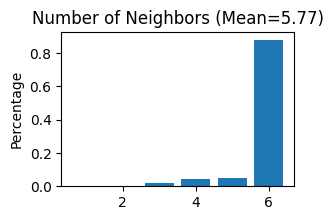

In [2]:
combined_comparison = run_stagate_mclust("/mnt/volume1/2023SRTP/library/cyr/simulation_results/domain/random_assign_domain.h5ad", num_cluster=7, used_obsm='STAGATE', random_seed=0)
# tissue_result = run_stagate_mclust("/mnt/volume1/2023SRTP/library/cyr/simulation_results/tissue/simulated_151673.h5ad", num_cluster=7, used_obsm='STAGATE', random_seed=0)
# noised_comparison = run_stagate_mclust("/mnt/volume1/2023SRTP/library/cyr/simulation_results/noise/simulated_noise_0.2.h5ad", num_cluster=7, used_obsm='STAGATE', random_seed=0)

/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1729414830.738212 3847896 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-20 17:00:30.738441: W tensorflow/core/common

fitting ...
  |======================================================================| 100%


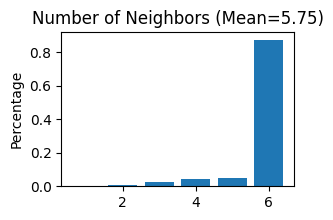

In [4]:

raw_result = run_stagate_mclust("/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad", num_cluster=7, used_obsm='STAGATE', random_seed=0)

ground_truth_labels = raw_result.obs['Ground Truth']
ground_truth_labels = ground_truth_labels.fillna('Layer_2')
raw_result.obs['Ground Truth'] = ground_truth_labels

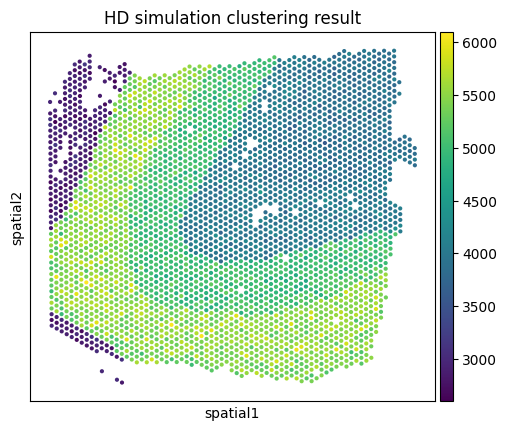

In [5]:
sc.pl.spatial(combined_comparison, color='total_counts', spot_size=100,title='HD simulation clustering result')

/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659560.099353 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659560.123992 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659597.060933 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659597.061193 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659653.749610 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659653.749864 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659724.185108 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659724.185377 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659782.395794 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659782.396123 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659858.646926 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659858.647185 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659917.817162 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659917.817520 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728659992.951725 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728659992.952006 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660041.877206 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660041.877468 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660099.617796 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660099.618077 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660177.401850 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660177.402116 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660221.473211 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660221.473475 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660271.217387 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660271.217684 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660331.993222 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660331.993481 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))


Size of Input:  (3580, 3001)


I0000 00:00:1728660402.382059 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660402.383257 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660402.383580 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660402.383965 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660455.329230 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660455.329487 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660499.211559 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660499.211932 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660554.076818 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660554.077079 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660607.643344 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660607.643609 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3001)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660646.244425 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660646.244987 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:148: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam 

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:42<00:00, 11.90it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660780.539656 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660780.539931 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660867.818868 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660867.819132 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728660960.520991 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728660960.521257 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661022.428197 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661022.428585 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661102.150843 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661102.151105 2013230 cuda_executor.

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:50<00:00, 10.00it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661181.867134 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661181.867400 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661272.557590 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661272.557862 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661336.490832 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661336.491877 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661413.922895 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661413.923158 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661501.172529 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661501.189696 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661598.878282 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661598.878632 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661688.928027 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661688.928295 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661821.308817 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661821.309076 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661881.295000 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661881.295257 2013230 cuda_executor.

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:50<00:00,  9.95it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728661960.866066 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728661960.866334 2013230 cuda_executor.

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:40<00:00, 12.49it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662017.271423 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662017.271666 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662104.015148 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662104.015424 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662190.931628 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662190.931884 2013230 cuda_executor.

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:53<00:00,  9.32it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662280.866711 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662280.866975 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662345.661230 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662345.661711 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662424.934501 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662424.934818 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662513.921307 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662513.921579 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662594.911519 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662594.911800 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662686.277413 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662686.277695 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662781.235100 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662781.235355 2013230 cuda_executor.

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:47<00:00, 10.53it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662847.793746 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662847.794205 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728662923.729475 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728662923.729748 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663011.543226 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663011.543513 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))


Size of Input:  (3580, 3000)


I0000 00:00:1728663081.464366 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663081.475522 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663081.485533 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663081.490177 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663153.436444 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663153.436703 2013230 cuda_executor.

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:57<00:00,  8.77it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663249.017740 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663249.017998 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663329.132140 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663329.132404 2013230 cuda_executor.

The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


100%|██████████| 500/500 [00:45<00:00, 10.96it/s]


fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663394.073750 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663394.074018 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663474.694557 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663474.694942 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663555.715846 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663555.716098 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663645.528864 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663645.529240 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663736.308730 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663736.309012 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663800.472016 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663800.472312 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%
------Calculating spatial graph...
The graph contains 20588 edges, 3580 cells.
5.7508 neighbors per cell on average.
Size of Input:  (3580, 3000)


/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
/home/srtp/anaconda3/envs/DestVI_env/lib/python3.9/site-packages/STAGATE-1.0.1-py3.9.egg/STAGATE/utils.py:146: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  plot_df = pd.value_counts(pd.value_counts(adata.uns['Spatial_Net']['Cell1']))
I0000 00:00:1728663881.077219 2013230 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1728663881.077530 2013230 cuda_executor.

fitting ...
  |======================================================================| 100%


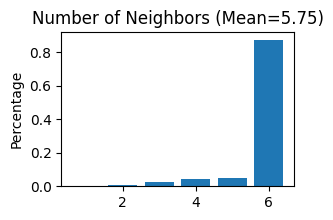

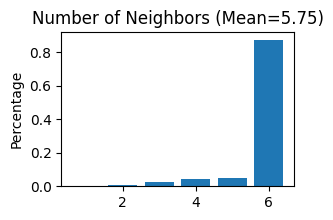

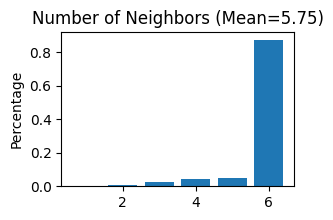

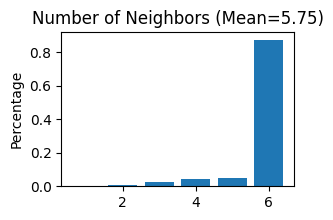

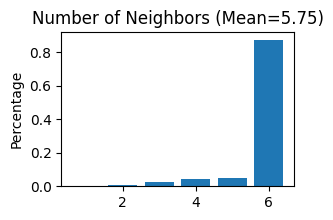

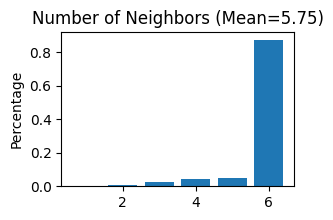

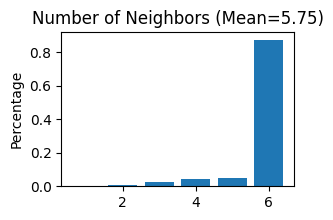

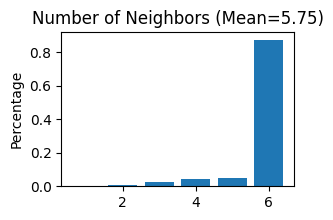

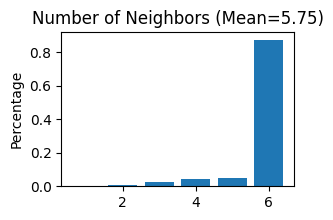

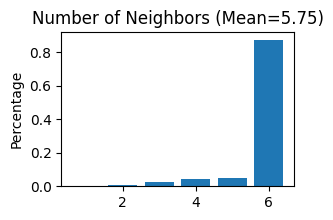

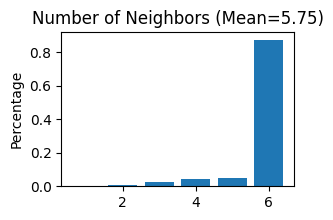

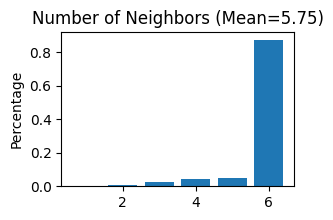

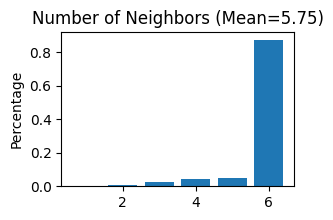

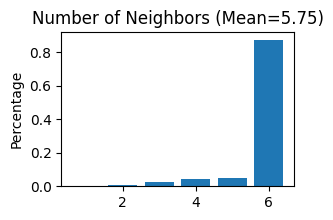

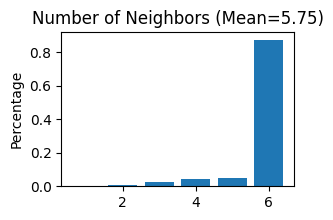

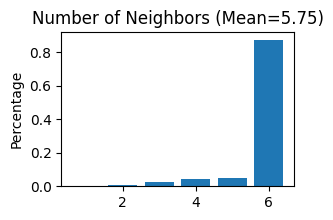

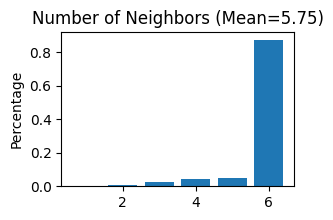

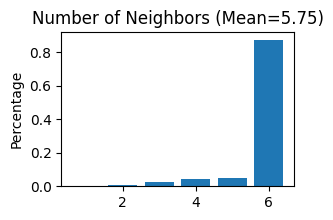

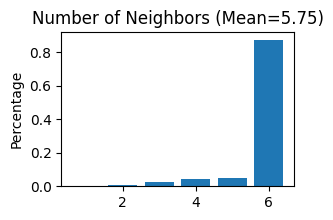

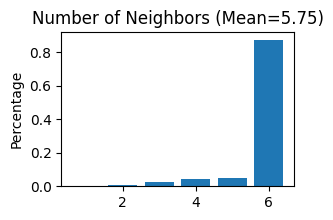

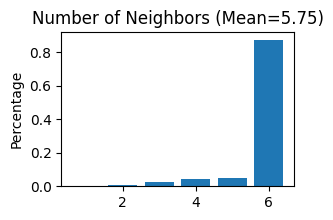

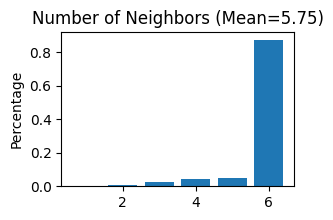

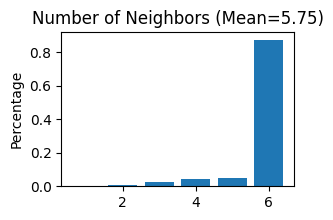

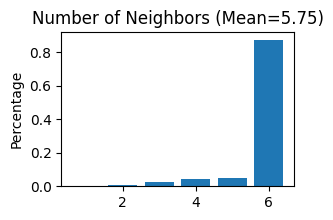

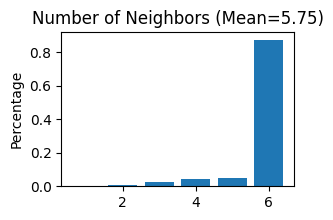

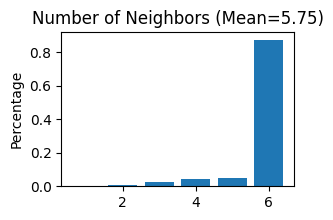

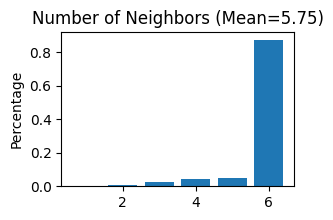

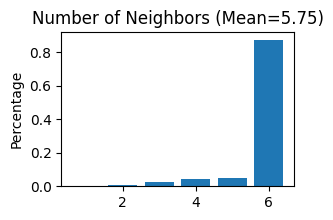

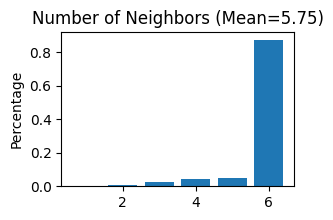

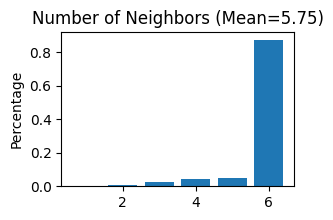

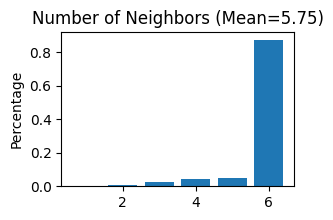

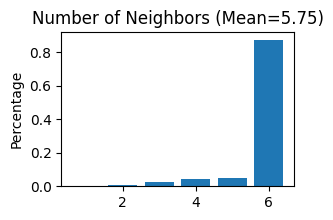

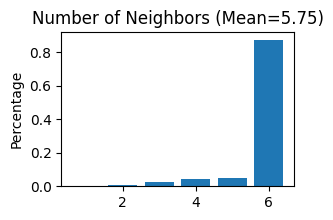

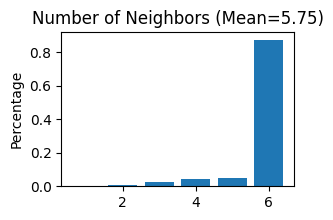

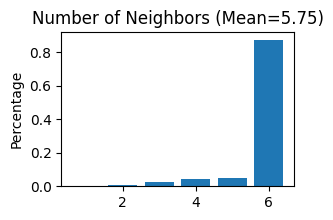

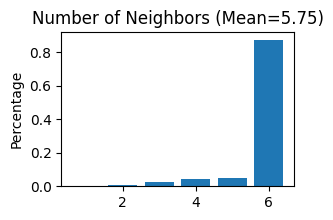

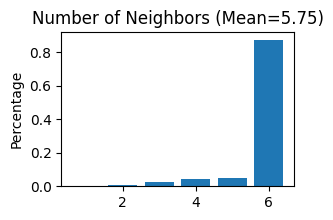

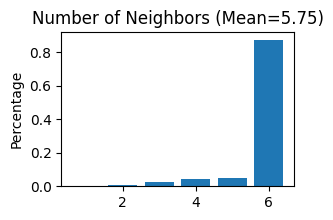

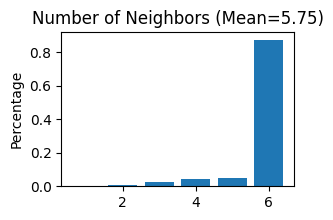

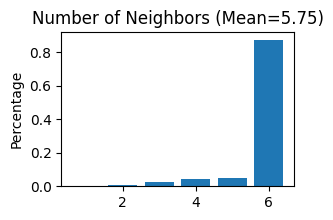

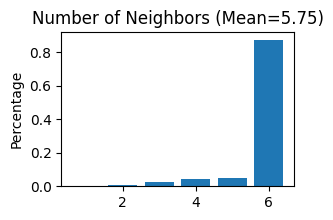

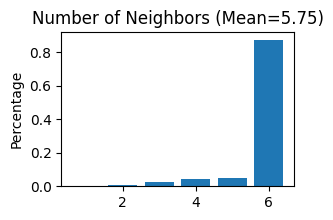

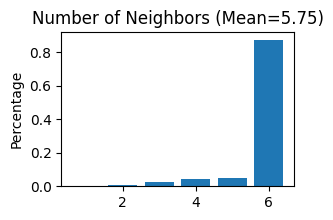

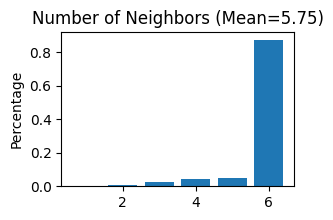

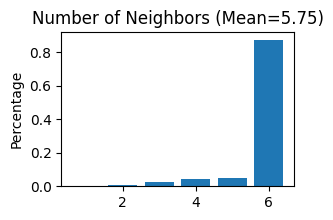

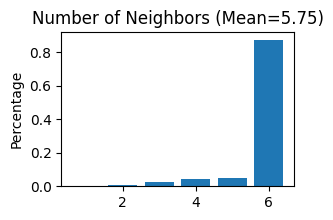

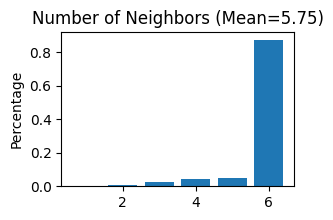

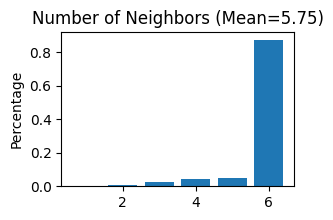

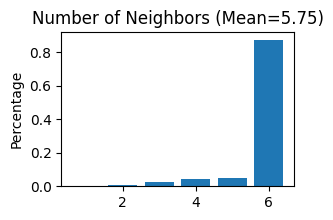

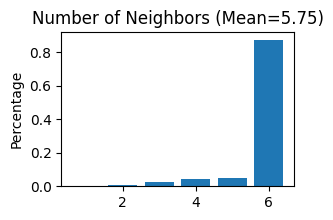

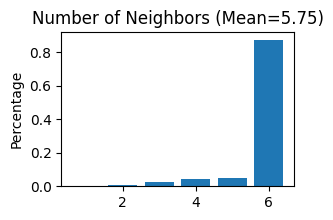

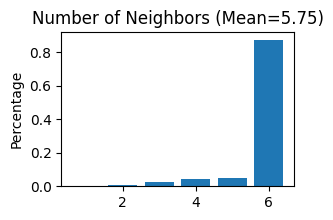

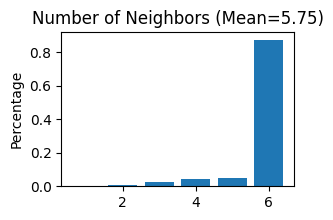

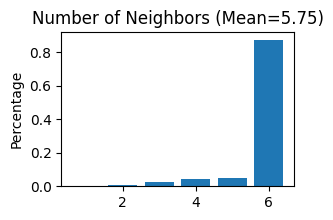

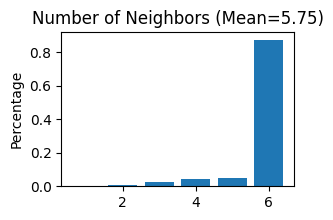

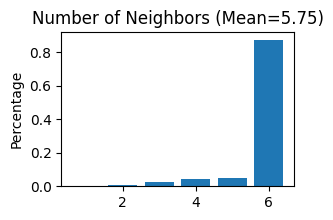

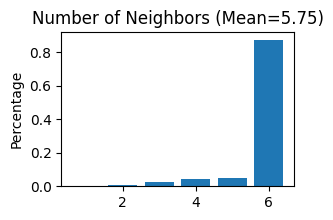

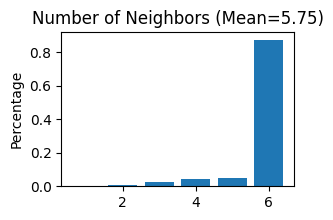

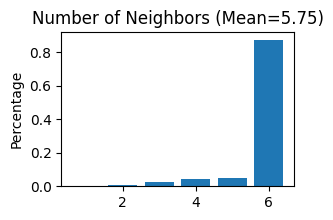

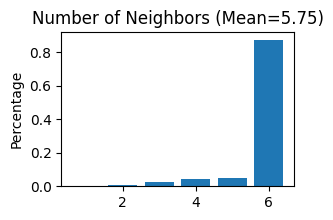

In [15]:
import scanpy as sc
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score
import seaborn as sns
import matplotlib.pyplot as plt

def run_multiple_times(adata_path, ground_truth_labels, num_cluster=7, used_obsm='STAGATE', n_runs=10):
    ari_scores = []
    for seed in range(n_runs):
        result = run_stagate_mclust(adata_path, num_cluster=num_cluster, used_obsm=used_obsm, random_seed=seed)
        clustering_labels = result.obs["mclust"]
        ari = adjusted_rand_score(ground_truth_labels, clustering_labels)
        ari_scores.append(ari)
    return ari_scores


ground_truth_labels = raw_result.obs["Ground Truth"]

# 运行多次并收集 ARI 结果
n_runs = 20  
ari_raw = run_multiple_times("/mnt/volume1/2023SRTP/library/cyr/processed_151673_filtered.h5ad", ground_truth_labels, n_runs=n_runs)
ari_tissue = run_multiple_times("/mnt/volume1/2023SRTP/library/cyr/simulation_results/tissue_version3.h5ad", ground_truth_labels, n_runs=n_runs)
ari_srtsim = run_multiple_times("/mnt/volume1/2023SRTP/library/cyr/simulation_results/simulated_combine.h5ad", ground_truth_labels, n_runs=n_runs)

# 组织数据以便进行可视化
df = pd.DataFrame({
    "ARI": ari_raw + ari_tissue + ari_srtsim,
    "Method": ['Raw'] * n_runs + ['Direct Simulation'] * n_runs + ['Combined Simulation'] * n_runs
})

# 绘制箱线图比较方法之间的 ARI 分布
plt.figure(figsize=(10, 6))
sns.boxplot(x='Method', y='ARI', data=df)
plt.title('Comparison of ARI Scores Across Different Methods')
plt.ylabel('ARI')
plt.xlabel('Method')
plt.savefig('/mnt/volume1/2023SRTP/library/cyr/simulation_results/ari_comparison.png')
plt.close()

In [12]:
import scanpy as sc
import numpy as np
from scipy.stats import pearsonr, spearmanr

# 加载AnnData对象
adata_original = raw_adata
adata_simulated = combine_sim_adata
# 提取表达矩阵
# 假设数据存储在adata.X中，通常是稀疏矩阵，因此将其转换为密集矩阵
original_expr = adata_original.X.toarray()
simulated_expr = adata_simulated.X.toarray()

# 计算相关矩阵
def calculate_correlation_matrix(expr_data):
    # 使用NumPy计算相关性
    return np.corrcoef(expr_data)

original_corr_matrix = calculate_correlation_matrix(original_expr)
simulated_corr_matrix = calculate_correlation_matrix(simulated_expr)

# 计算两个相关矩阵之间的相似性
def compare_correlation_matrices(matrix1, matrix2):
    # 提取上三角部分，不包括对角线
    triu_indices = np.triu_indices_from(matrix1, k=1)
    matrix1_flat = matrix1[triu_indices]
    matrix2_flat = matrix2[triu_indices]
    
    # 计算皮尔逊相关系数来衡量两个矩阵的相似性
    similarity, _ = pearsonr(matrix1_flat, matrix2_flat)
    return similarity

similarity_pearson = compare_correlation_matrices(original_corr_matrix, simulated_corr_matrix)
print(f"Correlation matrix similarity (Pearson): {similarity_pearson:.4f}")

# 使用斯皮尔曼相关系数进行比较
def compare_correlation_matrices_spearman(matrix1, matrix2):
    triu_indices = np.triu_indices_from(matrix1, k=1)
    matrix1_flat = matrix1[triu_indices]
    matrix2_flat = matrix2[triu_indices]
    
    # 计算斯皮尔曼相关系数
    similarity, _ = spearmanr(matrix1_flat, matrix2_flat)
    return similarity

similarity_spearman = compare_correlation_matrices_spearman(original_corr_matrix, simulated_corr_matrix)
print(f"Correlation matrix similarity (Spearman): {similarity_spearman:.4f}")

Correlation matrix similarity (Pearson): 0.8800
Correlation matrix similarity (Spearman): 0.9516


In [14]:
# 加载AnnData对象
adata_original = raw_adata
adata_simulated = tissue_adata
# 提取表达矩阵
# 假设数据存储在adata.X中，通常是稀疏矩阵，因此将其转换为密集矩阵
original_expr = adata_original.X.toarray()
simulated_expr = adata_simulated.X.toarray()

original_corr_matrix = calculate_correlation_matrix(original_expr)
simulated_corr_matrix = calculate_correlation_matrix(simulated_expr)

similarity_pearson = compare_correlation_matrices(original_corr_matrix, simulated_corr_matrix)
print(f"Correlation matrix similarity (Pearson): {similarity_pearson:.4f}")
similarity_spearman = compare_correlation_matrices_spearman(original_corr_matrix, simulated_corr_matrix)
print(f"Correlation matrix similarity (Spearman): {similarity_spearman:.4f}")

Correlation matrix similarity (Pearson): 0.9712
Correlation matrix similarity (Spearman): 0.9920
